# 15.S52 AI in Finance Final Project

Priscilla Clark, Siddharth Mehta, Derek Wang

## Load and prepare data

Join macro features to loan details while preventing look-ahead bias with interest rates

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [4]:
# Load data
mortgage_df = pd.read_csv('mortgage_data.csv')
hpi_df = pd.read_csv('hpi_state.csv')
rate_df = pd.read_csv('rate.csv')

/var/folders/tl/1_9jjfjj3wb0nqls4mbmjchw0000gn/T/ipykernel_74700/2272254199.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  mortgage_df = pd.read_csv('mortgage_data.csv')


In [5]:
hpi_df

,year,quarter,state,state_code,state_full,HPI_state
0,1975,1,AK,2,Alaska,61.580002
1,1975,2,AK,2,Alaska,63.060001
2,1975,3,AK,2,Alaska,67.699997
3,1975,4,AK,2,Alaska,66.779999
4,1976,1,AK,2,Alaska,73.070000
...,...,...,...,...,...,...
8971,2017,4,WY,56,Wyoming,309.510010
8972,2018,1,WY,56,Wyoming,315.810000
8973,2018,2,WY,56,Wyoming,316.209990
8974,2018,3,WY,56,Wyoming,320.450010


In [6]:
rate_df

,year,month,FRM30_rate,treasury_3mon_rate
0,2000,1,8.2100,5.32
1,2000,2,8.3250,5.55
2,2000,3,8.2400,5.69
3,2000,4,8.1525,5.66
4,2000,5,8.5150,5.79
...,...,...,...,...
226,2018,11,4.8660,2.33
227,2018,12,4.6375,2.37
228,2019,1,4.4640,2.37
229,2019,2,4.3700,2.39


In [7]:
mortgage_df

,source,loan_id,Year_orig,Quarter_orig,delinquent30,frst_dte,orig_rt,orig_amt,oltv,ocltv,dti,cscore_b,mi_pct,fthb_flg,num_bo,num_unit,state
0,FD,F100Q1023070,2000,1,0,4/1/2000,8.500,204000,79,79,37,643,0,N,2,1,AK
1,FD,F100Q1039162,2000,1,0,5/1/2000,8.375,100000,34,34,19,796,0,N,2,1,AK
2,FD,F100Q1050054,2000,1,0,3/1/2000,8.500,173000,95,95,43,698,25,N,2,1,AK
3,FD,F100Q1002153,2000,1,0,3/1/2000,8.125,137000,80,80,28,716,0,N,2,1,AL
4,FD,F100Q1005553,2000,1,0,3/1/2000,8.250,92000,95,95,42,680,30,N,2,1,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295832,FN,611000000000.0,2006,4,1,1/1/2007,6.250,123000,72,72,26,639,0,N,2,1,WY
295833,FN,661000000000.0,2006,4,0,12/1/2006,6.000,150000,64,64,45,720,0,Y,2,1,WY
295834,FN,665000000000.0,2006,4,1,2/1/2007,6.625,147000,80,90,52,691,0,N,1,1,WY
295835,FN,769000000000.0,2006,4,0,12/1/2006,6.250,176000,60,60,13,781,0,N,2,1,WY


In [8]:
# Get previous quarter for HPI join
mortgage_df['HPI_quarter'] = mortgage_df['Quarter_orig'] - 1
mortgage_df['HPI_year'] = mortgage_df['Year_orig']
mortgage_df.loc[mortgage_df['HPI_quarter'] == 0, 'HPI_quarter'] = 4
mortgage_df.loc[mortgage_df['HPI_quarter'] == 4, 'HPI_year'] = mortgage_df['Year_orig'] - 1

In [9]:
# Calculate rate month (first month of quarter - 1)
mortgage_df['rate_month'] = (mortgage_df['Quarter_orig'] - 1) * 3
mortgage_df['rate_year'] = mortgage_df['Year_orig']
mortgage_df.loc[mortgage_df['rate_month'] == 0, 'rate_month'] = 12
mortgage_df.loc[mortgage_df['rate_month'] == 12, 'rate_year'] = mortgage_df['Year_orig'] - 1

In [10]:
# Display distinct values for specified columns
distinct_values = mortgage_df[['Year_orig', 'Quarter_orig', 'HPI_quarter', 'HPI_year','rate_month','rate_year']].drop_duplicates()
distinct_values

,Year_orig,Quarter_orig,HPI_quarter,HPI_year,rate_month,rate_year
0,2000,1,4,1999,12,1999
3510,2000,2,1,2000,3,2000
9232,2000,3,2,2000,6,2000
15417,2000,4,3,2000,9,2000
20637,2001,1,4,2000,12,2000
25373,2001,2,1,2001,3,2001
32664,2001,3,2,2001,6,2001
39575,2001,4,3,2001,9,2001
45066,2002,1,4,2001,12,2001
49829,2002,2,1,2002,3,2002


In [11]:
# Join with previous quarter's HPI data
final_df = mortgage_df.merge(
    hpi_df[['year', 'quarter', 'state', 'HPI_state']],
    left_on=['HPI_year', 'HPI_quarter', 'state'],
    right_on=['year', 'quarter', 'state'],
    how='left'
)

# Join with rate data
final_df = final_df.merge(
    rate_df[['year', 'month', 'FRM30_rate', 'treasury_3mon_rate']],
    left_on=['rate_year', 'rate_month'],
    right_on=['year', 'month'],
    how='left'
)

In [12]:
print("\nSample of 5 loans to verify the joins:")
sample_cols = ['Year_orig', 'Quarter_orig', 'state', 'HPI_state', 'FRM30_rate', 'treasury_3mon_rate']
print(final_df[sample_cols].head().to_string())

print("\nShape of final dataset:", final_df.shape)


Sample of 5 loans to verify the joins:
   Year_orig  Quarter_orig state  HPI_state  FRM30_rate  treasury_3mon_rate
0       2000             1    AK     170.08         NaN                 NaN
1       2000             1    AK     170.08         NaN                 NaN
2       2000             1    AK     170.08         NaN                 NaN
3       2000             1    AL     208.33         NaN                 NaN
4       2000             1    AL     208.33         NaN                 NaN

Shape of final dataset: (295837, 28)


In [13]:
# Check for missing HPI_state values
loans_without_hpi = final_df[final_df['HPI_state'].isnull()]

distinct_values_missingHPI = loans_without_hpi[['state']].drop_duplicates()
distinct_values_missingHPI

,state
2825,PR
4919,GU
61832,VI


In [14]:
final_df

,source,loan_id,Year_orig,Quarter_orig,delinquent30,frst_dte,orig_rt,orig_amt,oltv,ocltv,...,HPI_year,rate_month,rate_year,year_x,quarter,HPI_state,year_y,month,FRM30_rate,treasury_3mon_rate
0,FD,F100Q1023070,2000,1,0,4/1/2000,8.500,204000,79,79,...,1999,12,1999,1999.0,4.0,170.08,NaN,NaN,NaN,NaN
1,FD,F100Q1039162,2000,1,0,5/1/2000,8.375,100000,34,34,...,1999,12,1999,1999.0,4.0,170.08,NaN,NaN,NaN,NaN
2,FD,F100Q1050054,2000,1,0,3/1/2000,8.500,173000,95,95,...,1999,12,1999,1999.0,4.0,170.08,NaN,NaN,NaN,NaN
3,FD,F100Q1002153,2000,1,0,3/1/2000,8.125,137000,80,80,...,1999,12,1999,1999.0,4.0,208.33,NaN,NaN,NaN,NaN
4,FD,F100Q1005553,2000,1,0,3/1/2000,8.250,92000,95,95,...,1999,12,1999,1999.0,4.0,208.33,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295832,FN,611000000000.0,2006,4,1,1/1/2007,6.250,123000,72,72,...,2006,9,2006,2006.0,3.0,255.00,2006.0,9.0,6.4025,4.81
295833,FN,661000000000.0,2006,4,0,12/1/2006,6.000,150000,64,64,...,2006,9,2006,2006.0,3.0,255.00,2006.0,9.0,6.4025,4.81
295834,FN,665000000000.0,2006,4,1,2/1/2007,6.625,147000,80,90,...,2006,9,2006,2006.0,3.0,255.00,2006.0,9.0,6.4025,4.81
295835,FN,769000000000.0,2006,4,0,12/1/2006,6.250,176000,60,60,...,2006,9,2006,2006.0,3.0,255.00,2006.0,9.0,6.4025,4.81


In [15]:
# Calculate missing value statistics
total_loans = len(final_df)
missing_stats = pd.DataFrame({
    'Missing_Count': final_df[['HPI_state', 'FRM30_rate', 'treasury_3mon_rate']].isnull().sum(),
    'Missing_Percentage': (final_df[['HPI_state', 'FRM30_rate', 'treasury_3mon_rate']].isnull().sum() / total_loans * 100).round(2)
})

print("Total number of loans:", total_loans)
print("\nMissing value statistics:")
print(missing_stats)

Total number of loans: 295837

Missing value statistics:
                    Missing_Count  Missing_Percentage
HPI_state                     406                0.14
FRM30_rate                   8854                2.99
treasury_3mon_rate           8854                2.99


In [16]:
# Handle nulls
# Option 1: Drop rows with nulls
df_clean = final_df.dropna(subset=['HPI_state', 'FRM30_rate', 'treasury_3mon_rate'])

In [17]:
# Calculate missing value statistics for all columns
total_loans = len(df_clean)
missing_stats = pd.DataFrame({
    'Missing_Count': df_clean.isnull().sum(),
    'Missing_Percentage': (df_clean.isnull().sum() / total_loans * 100).round(2)
})

# Only show columns with missing values
missing_stats = missing_stats[missing_stats['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

print("Total number of loans:", total_loans)
print("\nColumns with missing values:")
print(missing_stats)

Total number of loans: 286591

Columns with missing values:
Empty DataFrame
Columns: [Missing_Count, Missing_Percentage]
Index: []


## Baseline logistical regression (only mortgage loan features)

In [18]:
# Prepare features
# Drop ID and date fields that shouldn't be used in modeling
cols_to_drop = ['loan_id', 'frst_dte', 'HPI_quarter', 'HPI_year', 'rate_month', 'rate_year']
df = mortgage_df.drop(columns=cols_to_drop)

# Convert categorical variables to dummy variables
df_encoded = pd.get_dummies(df, columns=['source', 'state', 'fthb_flg'])

# Select all columns except the target variable
feature_cols = [col for col in df_encoded.columns if col != 'delinquent30']

X = df_encoded[feature_cols]
y = df_encoded['delinquent30']

# Split the data by year
years = df_encoded['Year_orig'].unique()
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.Series()
y_test = pd.Series()

# Ensure 70% of each year is included in training data
for year in years:
    year_mask = df_encoded['Year_orig'] == year
    X_year = X[year_mask]
    y_year = y[year_mask]

    # Split each year 70/30
    X_train_year, X_test_year, y_train_year, y_test_year = train_test_split(
        X_year, y_year, test_size=0.3, random_state=42
    )

    X_train = pd.concat([X_train, X_train_year])
    X_test = pd.concat([X_test, X_test_year])
    y_train = pd.concat([y_train, y_train_year])
    y_test = pd.concat([y_test, y_test_year])

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Get predicted probabilities
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

/var/folders/tl/1_9jjfjj3wb0nqls4mbmjchw0000gn/T/ipykernel_74700/2849200593.py:35: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_train = pd.concat([y_train, y_train_year])
/var/folders/tl/1_9jjfjj3wb0nqls4mbmjchw0000gn/T/ipykernel_74700/2849200593.py:36: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_test = pd.concat([y_test, y_test_year])


AUC: 0.738


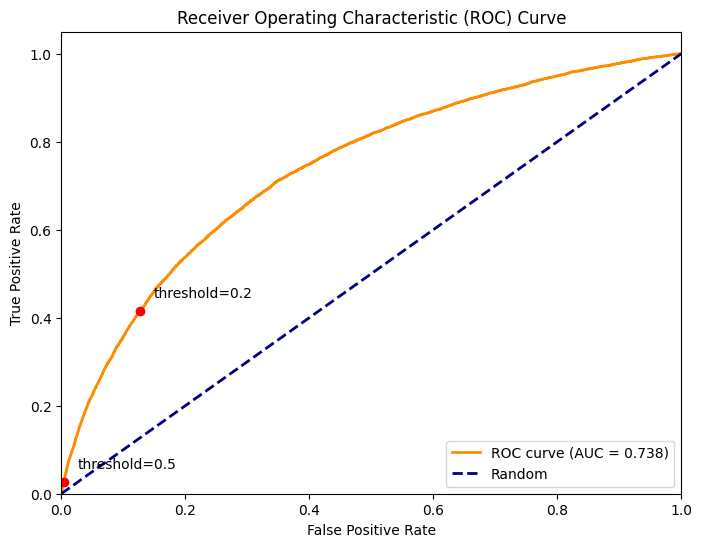

In [19]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Add vertical lines for thresholds 0.2 and 0.5
for threshold in [0.2, 0.5]:
    threshold_idx = np.abs(thresholds - threshold).argmin()
    plt.plot([fpr[threshold_idx]], [tpr[threshold_idx]], 'ro')
    plt.annotate(f'threshold={threshold}',
                (fpr[threshold_idx], tpr[threshold_idx]),
                xytext=(10, 10), textcoords='offset points')

print(f"AUC: {roc_auc:.3f}")

In [20]:
# Calculate metrics for both thresholds
for threshold in [0.5, 0.2]:
    y_pred = (y_pred_proba >= threshold).astype(int)
    print(f"\nConfusion Matrix (threshold = {threshold}):")
    print(confusion_matrix(y_test, y_pred))
    print(f"\nClassification Report (threshold = {threshold}):")
    print(classification_report(y_test, y_pred))


Confusion Matrix (threshold = 0.5):
[[77948   289]
 [10236   282]]

Classification Report (threshold = 0.5):
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     78237
           1       0.49      0.03      0.05     10518

    accuracy                           0.88     88755
   macro avg       0.69      0.51      0.49     88755
weighted avg       0.84      0.88      0.83     88755


Confusion Matrix (threshold = 0.2):
[[68297  9940]
 [ 6148  4370]]

Classification Report (threshold = 0.2):
              precision    recall  f1-score   support

           0       0.92      0.87      0.89     78237
           1       0.31      0.42      0.35     10518

    accuracy                           0.82     88755
   macro avg       0.61      0.64      0.62     88755
weighted avg       0.84      0.82      0.83     88755



## Baseline logistical regression model (all features)

In [21]:
# Prepare features
# Drop ID and date fields that shouldn't be used in modeling
cols_to_drop = ['loan_id', 'frst_dte', 'HPI_quarter', 'HPI_year', 'rate_month', 'rate_year',
                'year_x', 'year_y', 'quarter', 'month']
df = df_clean.drop(columns=cols_to_drop)

# Convert categorical variables to dummy variables
df_encoded = pd.get_dummies(df, columns=['source', 'state', 'fthb_flg'])

# Select all columns except the target variable
feature_cols = [col for col in df_encoded.columns if col != 'delinquent30']

X = df_encoded[feature_cols]
y = df_encoded['delinquent30']

# Split the data by year
years = df_encoded['Year_orig'].unique()
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.Series()
y_test = pd.Series()

# Ensure 70% of each year is included in training data
for year in years:
    year_mask = df_encoded['Year_orig'] == year
    X_year = X[year_mask]
    y_year = y[year_mask]

    # Split each year 70/30
    X_train_year, X_test_year, y_train_year, y_test_year = train_test_split(
        X_year, y_year, test_size=0.3, random_state=42
    )

    X_train = pd.concat([X_train, X_train_year])
    X_test = pd.concat([X_test, X_test_year])
    y_train = pd.concat([y_train, y_train_year])
    y_test = pd.concat([y_test, y_test_year])

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Get predicted probabilities
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

/var/folders/tl/1_9jjfjj3wb0nqls4mbmjchw0000gn/T/ipykernel_74700/843758414.py:36: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_train = pd.concat([y_train, y_train_year])
/var/folders/tl/1_9jjfjj3wb0nqls4mbmjchw0000gn/T/ipykernel_74700/843758414.py:37: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_test = pd.concat([y_test, y_test_year])


AUC: 0.741


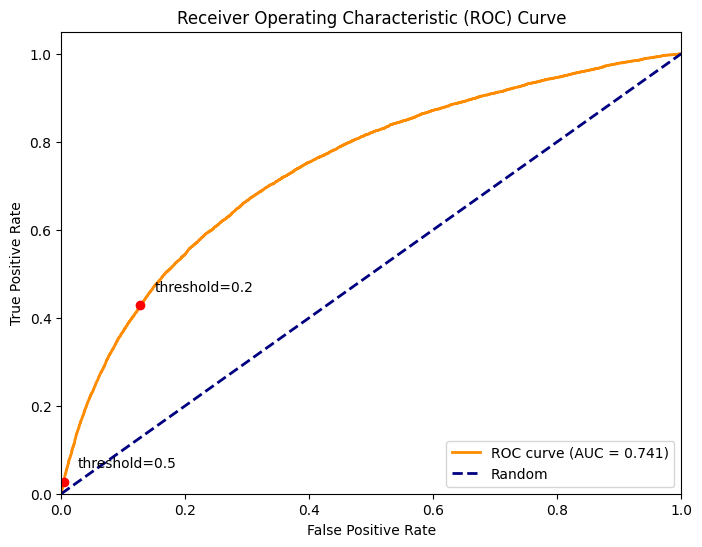

In [22]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Add vertical lines for thresholds 0.2 and 0.5
for threshold in [0.2, 0.5]:
    threshold_idx = np.abs(thresholds - threshold).argmin()
    plt.plot([fpr[threshold_idx]], [tpr[threshold_idx]], 'ro')
    plt.annotate(f'threshold={threshold}',
                (fpr[threshold_idx], tpr[threshold_idx]),
                xytext=(10, 10), textcoords='offset points')

print(f"AUC: {roc_auc:.3f}")

In [23]:
# Calculate metrics for both thresholds
for threshold in [0.5, 0.2]:
    y_pred = (y_pred_proba >= threshold).astype(int)
    print(f"\nConfusion Matrix (threshold = {threshold}):")
    print(confusion_matrix(y_test, y_pred))
    print(f"\nClassification Report (threshold = {threshold}):")
    print(classification_report(y_test, y_pred))


Confusion Matrix (threshold = 0.5):
[[75675   312]
 [ 9719   274]]

Classification Report (threshold = 0.5):
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     75987
           1       0.47      0.03      0.05      9993

    accuracy                           0.88     85980
   macro avg       0.68      0.51      0.49     85980
weighted avg       0.84      0.88      0.83     85980


Confusion Matrix (threshold = 0.2):
[[66278  9709]
 [ 5712  4281]]

Classification Report (threshold = 0.2):
              precision    recall  f1-score   support

           0       0.92      0.87      0.90     75987
           1       0.31      0.43      0.36      9993

    accuracy                           0.82     85980
   macro avg       0.61      0.65      0.63     85980
weighted avg       0.85      0.82      0.83     85980



In [24]:
# Print dataset info
print("\nDataset Information:")
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Number of features: {len(feature_cols)}")
print("\nFeature names:")
print(feature_cols)


Dataset Information:
Training set size: 200611
Test set size: 85980
Number of features: 70

Feature names:
['Year_orig', 'Quarter_orig', 'orig_rt', 'orig_amt', 'oltv', 'ocltv', 'dti', 'cscore_b', 'mi_pct', 'num_bo', 'num_unit', 'HPI_state', 'FRM30_rate', 'treasury_3mon_rate', 'source_FD', 'source_FN', 'state_AK', 'state_AL', 'state_AR', 'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DC', 'state_DE', 'state_FL', 'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IL', 'state_IN', 'state_KS', 'state_KY', 'state_LA', 'state_MA', 'state_MD', 'state_ME', 'state_MI', 'state_MN', 'state_MO', 'state_MS', 'state_MT', 'state_NC', 'state_ND', 'state_NE', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_RI', 'state_SC', 'state_SD', 'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VT', 'state_WA', 'state_WI', 'state_WV', 'state_WY', 'fthb_flg_N', 'fthb_flg_U', 'fthb_flg_Y']


## Improved logistic regression model (feature selection)



In [25]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns).reset_index(drop=True)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns).reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [26]:
# 1. Base Logistic Regression Feature Importance
print("Method 1: Base Logistic Regression Feature Importance")
base_model = LogisticRegression(random_state=42, max_iter=1000)
base_model.fit(X_train_scaled, y_train)

importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': abs(base_model.coef_[0])
})
importance = importance.sort_values('coefficient', ascending=False)
print("\nTop 20 most important features:")
print(importance.head(20))

Method 1: Base Logistic Regression Feature Importance

Top 20 most important features:
               feature  coefficient
7             cscore_b     0.712985
9               num_bo     0.240006
11           HPI_state     0.197154
2              orig_rt     0.191745
12          FRM30_rate     0.191004
34            state_LA     0.120094
59            state_TX     0.098107
35            state_MA     0.084667
6                  dti     0.076233
8               mi_pct     0.075725
13  treasury_3mon_rate     0.065887
20            state_CA     0.051585
64            state_WI     0.050655
4                 oltv     0.047522
41            state_MS     0.043968
69          fthb_flg_Y     0.043640
67          fthb_flg_N     0.043279
25            state_FL     0.042217
15           source_FN     0.041750
14           source_FD     0.041750


In [27]:
# 2. LASSO Feature Selection
print("\nMethod 2: LASSO Feature Selection")
lasso = LassoCV(cv=5, random_state=42, max_iter=1000)
lasso.fit(X_train_scaled, y_train)

lasso_importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': abs(lasso.coef_)
})
lasso_selected = lasso_importance[lasso_importance['coefficient'] > 0]
print(f"\nLASSO selected {len(lasso_selected)} features")
print("\nTop 20 LASSO selected features:")
print(lasso_selected.sort_values('coefficient', ascending=False).head(20))


Method 2: LASSO Feature Selection

LASSO selected 68 features

Top 20 LASSO selected features:
               feature  coefficient
7             cscore_b     0.078963
9               num_bo     0.025087
2              orig_rt     0.024152
12          FRM30_rate     0.020245
11           HPI_state     0.016045
34            state_LA     0.014501
8               mi_pct     0.010542
59            state_TX     0.009690
67          fthb_flg_N     0.009191
14           source_FD     0.008803
35            state_MA     0.006752
41            state_MS     0.004878
25            state_FL     0.004871
13  treasury_3mon_rate     0.004764
20            state_CA     0.004357
6                  dti     0.004217
64            state_WI     0.003746
17            state_AL     0.003619
0            Year_orig     0.003234
56            state_SC     0.002738


In [28]:
# 3. Stepwise Selection using p-values
print("\nMethod 3: Stepwise Selection using p-values")
def stepwise_selection(X, y, initial_features, threshold_in=0.01, threshold_out=0.05):
    selected_features = initial_features.copy()
    changed = True

    while changed:
        changed = False
        # Backward elimination
        model = sm.Logit(y, sm.add_constant(X[selected_features])).fit(disp=0)
        pvalues = model.pvalues[1:]  # Exclude constant
        worst_feature = pvalues.index[pvalues.argmax()]

        if pvalues[worst_feature] > threshold_out:
            selected_features.remove(worst_feature)
            changed = True
            print(f'Removed: {worst_feature} (p-value: {pvalues[worst_feature]:.4f})')

    return selected_features

# Start with top 50 features from LASSO to speed up computation
initial_features = lasso_selected.sort_values('coefficient', ascending=False).head(50)['feature'].tolist()
stepwise_features = stepwise_selection(X_train_scaled, y_train, initial_features)

print("\nFeatures selected by stepwise selection:")
print(stepwise_features)


Method 3: Stepwise Selection using p-values
Removed: Year_orig (p-value: 0.7260)
Removed: ocltv (p-value: 0.2875)
Removed: state_PA (p-value: 0.2467)
Removed: state_ID (p-value: 0.2387)
Removed: fthb_flg_U (p-value: 0.1756)
Removed: state_NC (p-value: 0.1640)
Removed: state_IN (p-value: 0.1858)
Removed: state_TN (p-value: 0.1402)
Removed: state_KS (p-value: 0.1430)
Removed: state_DE (p-value: 0.0964)

Features selected by stepwise selection:
['cscore_b', 'num_bo', 'orig_rt', 'FRM30_rate', 'HPI_state', 'state_LA', 'mi_pct', 'state_TX', 'fthb_flg_N', 'source_FD', 'state_MA', 'state_MS', 'state_FL', 'treasury_3mon_rate', 'state_CA', 'dti', 'state_WI', 'state_AL', 'state_SC', 'state_OK', 'state_GA', 'num_unit', 'state_NH', 'state_AR', 'state_DC', 'orig_amt', 'oltv', 'state_WA', 'state_IL', 'state_WV', 'state_NY', 'Quarter_orig', 'state_MD', 'state_OH', 'state_CO', 'state_RI', 'state_VA', 'state_MI', 'state_MN', 'state_OR']


In [29]:
# 4. Check multicollinearity using VIF
print("\nMethod 4: Variance Inflation Factor (VIF) Analysis")
def calculate_vif(X, threshold=5.0):
    selected_features = X.columns.tolist()
    while True:
        vif_data = pd.DataFrame()
        vif_data["feature"] = selected_features
        vif_data["VIF"] = [variance_inflation_factor(X[selected_features].values, i)
                          for i in range(len(selected_features))]

        if vif_data["VIF"].max() <= threshold:
            break

        max_vif_feature = vif_data.loc[vif_data["VIF"].idxmax(), "feature"]
        selected_features.remove(max_vif_feature)
        print(f"Removed {max_vif_feature} (VIF: {vif_data['VIF'].max():.2f})")

    return selected_features

# Use features from stepwise selection for VIF analysis
vif_features = calculate_vif(X_train_scaled[stepwise_features])
print("\nFeatures after VIF filtering:")
print(vif_features)


Method 4: Variance Inflation Factor (VIF) Analysis
Removed FRM30_rate (VIF: 6.86)

Features after VIF filtering:
['cscore_b', 'num_bo', 'orig_rt', 'HPI_state', 'state_LA', 'mi_pct', 'state_TX', 'fthb_flg_N', 'source_FD', 'state_MA', 'state_MS', 'state_FL', 'treasury_3mon_rate', 'state_CA', 'dti', 'state_WI', 'state_AL', 'state_SC', 'state_OK', 'state_GA', 'num_unit', 'state_NH', 'state_AR', 'state_DC', 'orig_amt', 'oltv', 'state_WA', 'state_IL', 'state_WV', 'state_NY', 'Quarter_orig', 'state_MD', 'state_OH', 'state_CO', 'state_RI', 'state_VA', 'state_MI', 'state_MN', 'state_OR']


In [30]:
# Compare model performance with different feature sets
def evaluate_feature_set(X_train, X_test, y_train, y_test, features, name):
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train[features], y_train)
    y_pred_proba = model.predict_proba(X_test[features])[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"{name} - AUC: {auc:.3f}")
    return auc

print("\nModel Performance Comparison:")
evaluate_feature_set(X_train_scaled, X_test_scaled, y_train, y_test, feature_cols, "All Features")
evaluate_feature_set(X_train_scaled, X_test_scaled, y_train, y_test, lasso_selected['feature'], "LASSO Selected")
evaluate_feature_set(X_train_scaled, X_test_scaled, y_train, y_test, stepwise_features, "Stepwise Selected")
evaluate_feature_set(X_train_scaled, X_test_scaled, y_train, y_test, vif_features, "VIF Filtered")

print("\nRecommended features (combining insights from all methods):")
recommended_features = set(vif_features) & set(lasso_selected['feature'].tolist())
print(list(recommended_features))


Model Performance Comparison:
All Features - AUC: 0.741
LASSO Selected - AUC: 0.741
Stepwise Selected - AUC: 0.741
VIF Filtered - AUC: 0.740

Recommended features (combining insights from all methods):
['state_NH', 'state_MD', 'state_OK', 'state_SC', 'state_FL', 'state_MI', 'state_WA', 'state_TX', 'fthb_flg_N', 'state_OH', 'state_WI', 'state_RI', 'state_CO', 'state_IL', 'oltv', 'source_FD', 'state_NY', 'state_CA', 'num_bo', 'mi_pct', 'HPI_state', 'state_AL', 'orig_rt', 'num_unit', 'orig_amt', 'state_MS', 'state_GA', 'state_MN', 'state_DC', 'state_VA', 'cscore_b', 'state_MA', 'state_AR', 'state_LA', 'treasury_3mon_rate', 'state_OR', 'state_WV', 'dti', 'Quarter_orig']


## Logistic regression model with best features

In [31]:
# Select best features from above
feature_cols = list(recommended_features)

# Filter out unneeded features
X = df_encoded[feature_cols]
y = df_encoded['delinquent30']

# Split the data by year
years = df_encoded['Year_orig'].unique()
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.Series()
y_test = pd.Series()

# Ensure 70% of each year is included in training data
for year in years:
    year_mask = df_encoded['Year_orig'] == year
    X_year = X[year_mask]
    y_year = y[year_mask]

    # Split each year 70/30
    X_train_year, X_test_year, y_train_year, y_test_year = train_test_split(
        X_year, y_year, test_size=0.3, random_state=42
    )

    X_train = pd.concat([X_train, X_train_year])
    X_test = pd.concat([X_test, X_test_year])
    y_train = pd.concat([y_train, y_train_year])
    y_test = pd.concat([y_test, y_test_year])

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Get predicted probabilities
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

/var/folders/tl/1_9jjfjj3wb0nqls4mbmjchw0000gn/T/ipykernel_74700/1470532022.py:28: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_train = pd.concat([y_train, y_train_year])
/var/folders/tl/1_9jjfjj3wb0nqls4mbmjchw0000gn/T/ipykernel_74700/1470532022.py:29: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_test = pd.concat([y_test, y_test_year])


AUC: 0.740


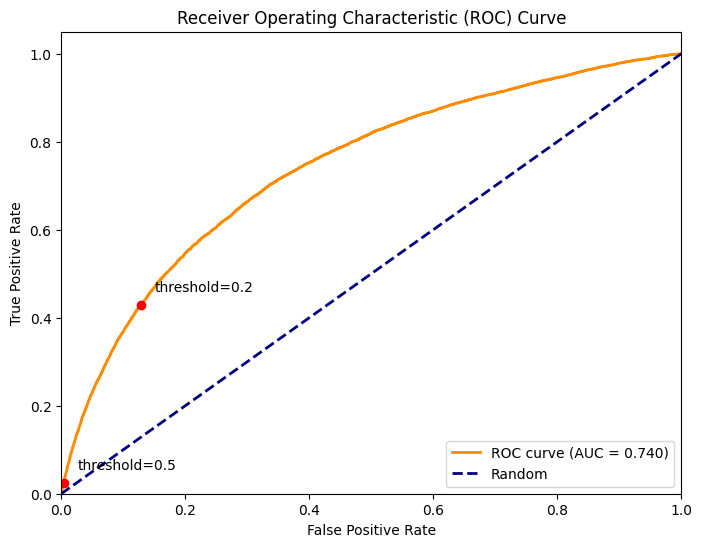

In [32]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Add vertical lines for thresholds 0.2 and 0.5
for threshold in [0.2, 0.5]:
    threshold_idx = np.abs(thresholds - threshold).argmin()
    plt.plot([fpr[threshold_idx]], [tpr[threshold_idx]], 'ro')
    plt.annotate(f'threshold={threshold}',
                (fpr[threshold_idx], tpr[threshold_idx]),
                xytext=(10, 10), textcoords='offset points')

print(f"AUC: {roc_auc:.3f}")

In [33]:
# Calculate metrics for both thresholds
for threshold in [0.5, 0.2]:
    y_pred = (y_pred_proba >= threshold).astype(int)
    print(f"\nConfusion Matrix (threshold = {threshold}):")
    print(confusion_matrix(y_test, y_pred))
    print(f"\nClassification Report (threshold = {threshold}):")
    print(classification_report(y_test, y_pred))


Confusion Matrix (threshold = 0.5):
[[75703   284]
 [ 9748   245]]

Classification Report (threshold = 0.5):
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     75987
           1       0.46      0.02      0.05      9993

    accuracy                           0.88     85980
   macro avg       0.67      0.51      0.49     85980
weighted avg       0.84      0.88      0.83     85980


Confusion Matrix (threshold = 0.2):
[[66234  9753]
 [ 5707  4286]]

Classification Report (threshold = 0.2):
              precision    recall  f1-score   support

           0       0.92      0.87      0.90     75987
           1       0.31      0.43      0.36      9993

    accuracy                           0.82     85980
   macro avg       0.61      0.65      0.63     85980
weighted avg       0.85      0.82      0.83     85980



In [34]:
# Print dataset info
print("\nDataset Information:")
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Number of features: {len(feature_cols)}")
print("\nFeature names:")
print(feature_cols)


Dataset Information:
Training set size: 200611
Test set size: 85980
Number of features: 39

Feature names:
['state_NH', 'state_MD', 'state_OK', 'state_SC', 'state_FL', 'state_MI', 'state_WA', 'state_TX', 'fthb_flg_N', 'state_OH', 'state_WI', 'state_RI', 'state_CO', 'state_IL', 'oltv', 'source_FD', 'state_NY', 'state_CA', 'num_bo', 'mi_pct', 'HPI_state', 'state_AL', 'orig_rt', 'num_unit', 'orig_amt', 'state_MS', 'state_GA', 'state_MN', 'state_DC', 'state_VA', 'cscore_b', 'state_MA', 'state_AR', 'state_LA', 'treasury_3mon_rate', 'state_OR', 'state_WV', 'dti', 'Quarter_orig']


## Test different models with best features

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, classification_report
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [36]:
# Prepare features
# Drop ID and date fields that shouldn't be used in modeling
cols_to_drop = ['loan_id', 'frst_dte', 'HPI_quarter', 'HPI_year', 'rate_month', 'rate_year',
                'year_x', 'year_y', 'quarter', 'month']
df = df_clean.drop(columns=cols_to_drop)

# Convert categorical variables to dummy variables
df_encoded = pd.get_dummies(df, columns=['source', 'state', 'fthb_flg'])

# Select all columns except the target variable
feature_cols = [col for col in df_encoded.columns if col != 'delinquent30']

X = df_encoded[feature_cols]
y = df_encoded['delinquent30']

# Split the data by year
years = df_encoded['Year_orig'].unique()
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.Series()
y_test = pd.Series()

# Ensure 70% of each year is included in training data
for year in years:
    year_mask = df_encoded['Year_orig'] == year
    X_year = X[year_mask]
    y_year = y[year_mask]

    # Split each year 70/30
    X_train_year, X_test_year, y_train_year, y_test_year = train_test_split(
        X_year, y_year, test_size=0.3, random_state=42
    )

    X_train = pd.concat([X_train, X_train_year])
    X_test = pd.concat([X_test, X_test_year])
    y_train = pd.concat([y_train, y_train_year])
    y_test = pd.concat([y_test, y_test_year])

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [38]:
# Use only recommended features
recommended_features = list(recommended_features)
X_train_selected = X_train_scaled[recommended_features]
X_test_selected = X_test_scaled[recommended_features]

In [39]:
# Dictionary to store results
model_results = {}

In [40]:
# 1. Logistic Regression
print("Tuning Logistic Regression...")
lr_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'class_weight': [None, 'balanced'],
    'max_iter': [1000],
    'penalty': ['none', 'l2'],
    'solver': ['lbfgs', 'liblinear']
}

lr = LogisticRegression(random_state=42)
lr_grid = GridSearchCV(lr, lr_params, scoring='roc_auc', cv=5, n_jobs=-1)
lr_grid.fit(X_train_selected, y_train)

print(f"Best LR parameters: {lr_grid.best_params_}")
lr_pred_proba = lr_grid.predict_proba(X_test_selected)[:, 1]
lr_auc = roc_auc_score(y_test, lr_pred_proba)
model_results['Logistic Regression'] = {
    'auc': lr_auc,
    'best_params': lr_grid.best_params_,
    'model': lr_grid.best_estimator_
}
print(model_results['Logistic Regression'])

Tuning Logistic Regression...
Best LR parameters: {'C': 0.001, 'class_weight': None, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
{'auc': np.float64(0.7405167180003881), 'best_params': {'C': 0.001, 'class_weight': None, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}, 'model': LogisticRegression(C=0.001, max_iter=1000, random_state=42, solver='liblinear')}


In [ ]:
# 2. Random Forest
print("\nTuning Random Forest...")
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'class_weight': ['balanced', None]
}

rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, rf_params, scoring='roc_auc', cv=5, n_jobs=-1)
rf_grid.fit(X_train_selected, y_train)

print(f"Best RF parameters: {rf_grid.best_params_}")
rf_pred_proba = rf_grid.predict_proba(X_test_selected)[:, 1]
rf_auc = roc_auc_score(y_test, rf_pred_proba)
model_results['Random Forest'] = {
    'auc': rf_auc,
    'best_params': rf_grid.best_params_,
    'model': rf_grid.best_estimator_
}
print(model_results['Random Forest'])


Tuning Random Forest...


In [ ]:
# 3. XGBoost
print("\nTuning XGBoost...")
xgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5]
}

xgb_model = xgb.XGBClassifier(random_state=42)
xgb_grid = GridSearchCV(xgb_model, xgb_params, scoring='roc_auc', cv=5, n_jobs=-1)
xgb_grid.fit(X_train_selected, y_train)

print(f"Best XGB parameters: {xgb_grid.best_params_}")
xgb_pred_proba = xgb_grid.predict_proba(X_test_selected)[:, 1]
xgb_auc = roc_auc_score(y_test, xgb_pred_proba)
model_results['XGBoost'] = {
    'auc': xgb_auc,
    'best_params': xgb_grid.best_params_,
    'model': xgb_grid.best_estimator_
}
print(model_results['XGBoost'])

In [ ]:
# 4. SVM
print("\nTuning SVM...")
svm_params = {
    'C': [0.1, 1, 10]
}

svm = SVC(probability=True, random_state=42)
svm_grid = GridSearchCV(svm, svm_params, scoring='roc_auc', cv=5, n_jobs=-1)
svm_grid.fit(X_train_selected, y_train)

print(f"Best SVM parameters: {svm_grid.best_params_}")
svm_pred_proba = svm_grid.predict_proba(X_test_selected)[:, 1]
svm_auc = roc_auc_score(y_test, svm_pred_proba)
model_results['SVM'] = {
    'auc': svm_auc,
    'best_params': svm_grid.best_params_,
    'model': svm_grid.best_estimator_
}
print(model_results['SVM'])

### Compare results of different models

In [ ]:
# Compare results
print("\nModel Comparison:")
results_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'AUC': [results['auc'] for results in model_results.values()]
}).sort_values('AUC', ascending=False)
print(results_df)

# Get best model
best_model_name = results_df.iloc[0]['Model']
best_model = model_results[best_model_name]['model']
print(f"\nBest Model: {best_model_name}")
print(f"Best Parameters: {model_results[best_model_name]['best_params']}")

In [ ]:
# Generate predictions using different thresholds for best model
thresholds = [0.2, 0.5]
for threshold in thresholds:
    print(f"\nClassification Report for {best_model_name} (threshold = {threshold}):")
    y_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)
    print(classification_report(y_test, y_pred))

In [ ]:
# Feature importance for best model (if available)
if hasattr(best_model, 'feature_importances_'):
    print("\nFeature Importances:")
    importances = pd.DataFrame({
        'feature': list(recommended_features),
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    print(importances)
elif hasattr(best_model, 'coef_'):
    print("\nFeature Coefficients:")
    importances = pd.DataFrame({
        'feature': list(recommended_features),
        'coefficient': abs(best_model.coef_[0])
    }).sort_values('coefficient', ascending=False)
    print(importances)

## Run best model and show AUC